# Import libraries

In [211]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import preprocessing
import time
import geohash as gh
from sklearn.metrics import mean_squared_error, r2_score
import geopandas
from scipy.stats import uniform,loguniform


# Useful functions

In [4]:
def scatterplot(x,y):
    plt.scatter(x, y, label= "stars", color= "green",  
            marker= "*", s=30) 
    # x-axis label 
    plt.xlabel('x - axis') 
    # frequency label 
    plt.ylabel('y - axis') 
    # plot title 
    plt.title('My scatter plot!') 
    # showing legend 
    plt.legend() 

    # function to show the plot 
    plt.show()
def histplot(x,y,bins):
    plt.hist(y, bins, x, color = 'green', 
        histtype = 'bar', rwidth = 0.8) 
  
    # x-axis label 
    plt.xlabel('x - axis') 
    # frequency label 
    plt.ylabel('y - axis') 
    # plot title 
    plt.title('My histogram') 

    # function to show the plot 
    plt.show() 
def removeinvalid(df,df_series):
    df = df[df_series>0]
    return df
def treat_outlier(df_series):
    Q1=df_series.quantile(0.25)
    Q3=df_series.quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1-9*IQR
    Upper_Whisker = Q3+9*IQR
    return Lower_Whisker,Upper_Whisker
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Data preparation

In [5]:
df= pd.read_csv('data/yellow_tripdata_2016-01.csv')

In [6]:
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


## A. Handle missing values

In [7]:
df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

Conclusion: there is no missing value for any columns. So we don't need to deal with any missing value

## B. first feature engineering

In [8]:
#add the trip duration
df['trip_duration'] = (pd.to_datetime(df['tpep_dropoff_datetime'])-pd.to_datetime(df['tpep_pickup_datetime'])).dt.total_seconds()*(1/3600)

In [9]:
#add the pickup date/hour/weekday
df['pickup_date'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.date
df['pickup_weekday'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.weekday
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour

In [10]:
#add the speed 
df['trip_speed'] = df['trip_distance']/df['trip_duration']

In [11]:
#add the pickup/dropoff_locationid
#hash the longitude and latitude into hashcode with length of 5
df['pickup_hash'] = df.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1)
df['dropoff_hash'] = df.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1)
#Use labelencoder to transform hashcode into numeric label
le = preprocessing.LabelEncoder()
df['pickup_locationid'] = le.fit_transform(df['pickup_hash'])
df['dropoff_locationid'] = le.fit_transform(df['dropoff_hash'])

In [12]:
df_copy = df

In [429]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,total_amount,trip_duration,pickup_date,pickup_weekday,pickup_hour,trip_speed,pickup_hash,dropoff_hash,pickup_locationid,dropoff_locationid
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,8.8,0.000000,2016-01-01,4,0,inf,dr5rs,dr5rs,203,263
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,19.3,0.000000,2016-01-01,4,0,inf,dr5rs,dr5rt,203,264
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,34.3,0.000000,2016-01-01,4,0,inf,dr5rk,dr72j,197,410
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,17.3,0.000000,2016-01-01,4,0,inf,dr5rs,dr5rk,203,257
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,8.8,0.000000,2016-01-01,4,0,inf,dr72h,dr5ru,331,265
5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,20.3,0.308333,2016-01-01,4,0,17.902703,dr5ru,dr5ry,205,269
6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,...,27.3,0.445833,2016-01-01,4,0,16.710280,dr5rs,dr72h,203,409
7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,...,10.3,0.198333,2016-01-01,4,0,6.050420,dr5ru,dr5ru,205,265
8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,...,19.3,0.186667,2016-01-01,4,0,32.142857,dr72j,dr72m,332,412
9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,...,12.8,0.185000,2016-01-01,4,0,17.351351,dr5rs,dr5rk,203,257


## C. Handle outliers

### 1. check and remove unreasonable trip distance

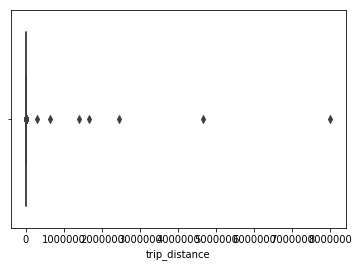

In [436]:

sns.boxplot(data=df,x=df['trip_distance'])
plt.show()

In [13]:
lower,upper =  treat_outlier(df['trip_distance'])

In [14]:
print(lower,upper)

-17.72 21.799999999999997


In [15]:
len(df)

10906858

In [16]:
#drop those observation with trip distance <=0 and >uppper

df = df[(df['trip_distance']>0) & (df['trip_distance']<upper)]


In [17]:
print ('The shortest trip is {}, and the longest trip is {}'.format(df['trip_distance'].min(),df['trip_distance'].max()))

The shortest trip is 0.01, and the longest trip is 21.79


### 2. check and remove the unreasonable trip duration

In [18]:

print ('The shortest duration is {}, while the longest duration is {}'.format(df['trip_duration'].min(),df['trip_duration'].max()))

The shortest duration is -0.7325, while the longest duration is 1998.545


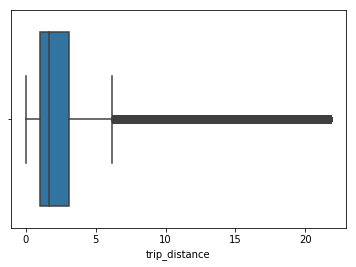

In [467]:
sns.boxplot(data=df,x=df['trip_distance'])
plt.show()

In [19]:
lower,upper = treat_outlier(df['trip_duration'])
print (lower,upper)

-1.4661111111111114 1.8536111111111113


In [20]:
#remove those trip has duration smaller than 30s and longer than 24 hours
df = df[(df['trip_duration']>0.01)  & (df['trip_duration']<24)]
print ('The shortest duration is {}, while the longest duration is {}'.format(df['trip_duration'].min(),df['trip_duration'].max()))

The shortest duration is 0.010277777777777778, while the longest duration is 23.999444444444446


In [21]:
len(df)

10800494

### 3. check and remove unreasonable speed

In [22]:

print ('The lowest speed is {} m/h, while the highest speed is {} m/h'.format(df['trip_speed'].min(),df['trip_speed'].max()))

The lowest speed is 0.0004171494785631518 m/h, while the highest speed is 2036.842105263158 m/h


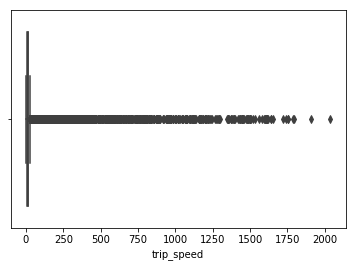

In [478]:
sns.boxplot(data=df,x=df['trip_speed'])
plt.show()

In [23]:
#remove the trip with average speed <5mile/hour which is person walk speed, >100miles/hour which is a bit higher than the speed limit on highway
df = df[(df['trip_speed']>5) & (df['trip_speed']<100)]
print ('The lowest speed is {} m/h, while the highest speed is {} m/h'.format(df['trip_speed'].min(),df['trip_speed'].max()))

The lowest speed is 5.000494315373208 m/h, while the highest speed is 99.69230769230771 m/h


In [24]:
len(df)

10246683

In [25]:
df_copy2 = df

### 4. check the invalid pickup/ dropoff location

In [ ]:
#check the pickup location on map
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.pickup_longitude, df.pickup_latitude))
print(gdf.head())
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
# We restrict to N
ax = world[world.continent == 'South America'].plot(color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()



In [26]:
new_cols = ['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RatecodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'pickup_date',
 'pickup_weekday',
 'pickup_hour',
 'trip_speed',
 'pickup_hash',
 'dropoff_hash',
 'pickup_locationid',
 'dropoff_locationid','trip_duration']

In [27]:
df = df[new_cols]

In [28]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,total_amount,pickup_date,pickup_weekday,pickup_hour,trip_speed,pickup_hash,dropoff_hash,pickup_locationid,dropoff_locationid,trip_duration
5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,20.3,2016-01-01,4,0,17.902703,dr5ru,dr5ry,205,269,0.308333
6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,...,27.3,2016-01-01,4,0,16.710280,dr5rs,dr72h,203,409,0.445833
7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,...,10.3,2016-01-01,4,0,6.050420,dr5ru,dr5ru,205,265,0.198333
8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,...,19.3,2016-01-01,4,0,32.142857,dr72j,dr72m,332,412,0.186667
9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,...,12.8,2016-01-01,4,0,17.351351,dr5rs,dr5rk,203,257,0.185000


#assumptions:
All the numeric attributes can not be negative. This operation remove all the invalid transaction, such as refund or cancellation.

## D. Split the dataset into training, validation and test

In [29]:
#split the data into training, evalution and test
data = df
data_train, data_test = train_test_split(data, test_size=0.4, random_state=42)
data_validation,data_test = train_test_split(data_test, test_size=0.5, random_state=43)
print('Split the data into training set with size of {}, validation set with size of {}, test set with size of {}'.format(len(data_train), len(data_validation), len(data_test)))

Split the data into training set with size of 6148009, validation set with size of 2049337, test set with size of 2049337


In [30]:
#save to csv
data_train.to_csv('data/data-training.csv', index = False)
data_validation.to_csv('data/data-validation.csv', index = False)
data_test.to_csv('data/data-test.csv', index = False)

# Exploratory Data Analysis

In [31]:
#load the prepared training dataset
training_df = pd.read_csv('data/data-training.csv')

In [101]:
training_df.head(1000)

,VendorID,pickup_locationid,dropoff_locationid,pickup_date,pickup_weekday,pickup_hour,trip_speed,passenger_count,trip_distance,trip_duration,pickup_day
0,1,210,265,2016-01-13,2,10,22.562674,1,9.00,0.398889,NaN
1,2,205,263,2016-01-08,4,8,8.109331,1,2.39,0.294722,NaN
2,2,205,266,2016-01-01,4,19,16.767123,1,1.02,0.060833,NaN
3,2,205,252,2016-01-31,6,19,8.081633,1,1.87,0.231389,NaN
4,1,205,263,2016-01-02,5,10,12.244898,1,1.00,0.081667,NaN
5,1,205,265,2016-01-30,5,16,11.148387,1,2.40,0.215278,1.0
6,1,205,409,2016-01-15,4,18,11.012658,2,2.90,0.263333,1.0
7,2,205,254,2016-01-11,0,8,6.120000,2,0.68,0.111111,1.0
8,1,210,265,2016-01-08,4,18,20.686922,1,8.70,0.420556,1.0
9,1,332,410,2016-01-06,2,17,11.732419,1,1.90,0.161944,1.0


In [40]:
training_df_copy = training_df

In [54]:
training_df = training_df_copy

In [102]:
training_df['pickup_day'] = pd.to_datetime(df['tpep_pickup_datetime'],infer_datetime_format=True).dt.day

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## A. Feature selection:
NOTE: It is important that you use only those features that are available to your algorithm when
the Maps app generates the ETA at the start of the taxi trip. Therefore, you cannot use any of
the features related to to the final fare/pricing, because those are not known until after the trip
has completed. Specifically, you cannot use these features: payment_type, fare_amount,
extra, MTA_tax, improvement_surcharge, tip_amount, tolls_amount, and
total_amount, store_and_fwd_flag.
Also tpep_dropoff_datetime can not be used.

In [33]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RatecodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'pickup_date',
 'pickup_weekday',
 'pickup_hour',
 'trip_speed',
 'pickup_hash',
 'dropoff_hash',
 'pickup_locationid',
 'dropoff_locationid',
 'trip_duration']

In [131]:
feature_names = ['VendorID','pickup_locationid',
 'dropoff_locationid','pickup_day',
 'pickup_weekday',
 'pickup_hour','passenger_count',
 'trip_distance']
label = ['trip_duration']

In [120]:
train_df = training_df[feature_names+label]

In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6148009 entries, 0 to 6148008
Data columns (total 10 columns):
VendorID              int64
pickup_locationid     int64
dropoff_locationid    int64
pickup_day            float64
pickup_weekday        int64
pickup_hour           int64
trip_speed            float64
passenger_count       int64
trip_distance         float64
trip_duration         float64
dtypes: float64(4), int64(6)
memory usage: 469.1 MB


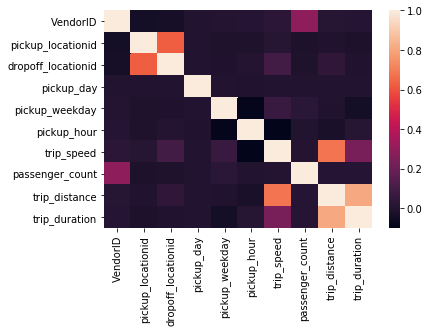

In [110]:
sns.heatmap(train_df.corr())

In [123]:
#remove missing value:
train_df = train_df[train_df['pickup_day'].notna()]
print (len(train_df))

5735100


In [124]:
#sample a smaller dataset for training
train_df = train_df.sample(frac=0.1,replace=False,random_state=1)

In [129]:
#Compute the feature importance with RFR
start = time.time()
X_train = train_df[feature_names]
y_train = train_df[label]
reg = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1)
# Train the classifier
reg.fit(X_train, y_train)
end = time.time()
print (end-start)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


145.9424810409546


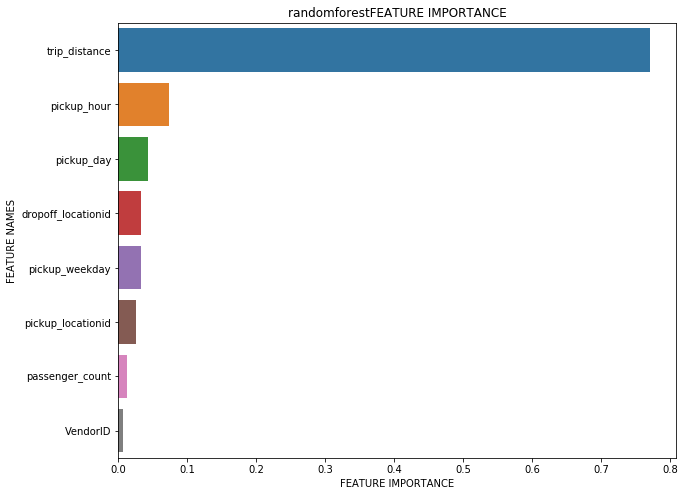

In [132]:
importance = reg.feature_importances_
plot_feature_importance(importance,feature_names,'randomforest')

In [133]:
reg.score(X_train,y_train)

0.9717469885180434

#Based on the Randomforest results, trip distance is most correlated to duration. pickup_hour,offEncoder, passenger_count, upEncoder,  are all significant features. Therefore, in the prediction model, these 5 features will be used as inputs. 

## B. Time series analysis

In [ ]:
date_df = training_df[['trip_duration','pickup_date'],index = 'pickup_date']

# Build model

## A. load data and sample data

In [147]:
#load data:
train_data = pd.read_csv('data/data-training.csv')
validation_data = pd.read_csv('data/data-validation.csv')
test_data = pd.read_csv('data/data-test.csv')

In [158]:
#sampling data:
train_data = train_data.sample(frac = 0.1, replace=False, random_state = 1)
test_data = test_data.sample(frac = 0.1, replace=False, random_state = 1)
validation_data= validation_data.sample(frac = 0.1, replace=False, random_state = 1)
print ('train_size: {}, validation_size: {}, test_size: {}'.format(len(train_data),len(validation_data),len(test_data)))

train_size: 614801, validation_size: 204934, test_size: 204934


In [159]:
#Create inputs for model
X_train,y_train = train_data[feature_names],train_data[label]
X_validation,y_validation = validation_data[feature_names],validation_data[label]
X_test,y_test = test_data[feature_names],test_data[label]

## B. Initialize estimators and param_grid

In [202]:
#random forest regressor
rfr = RandomForestRegressor()
rfr_grid = {
    'bootstrap': [True],
    'max_depth': [80],
    'max_features': [1],
    'min_samples_leaf': [5],
    'min_samples_split': [12],
    'n_estimators': [200]
}
#gradient boost regressor
gbr = GradientBoostingRegressor()
gbr_grid = {
    "learning_rate": [0.5],
    "min_samples_split": [12],
    "min_samples_leaf": [5],
    "max_depth":[8],
    "max_features":["sqrt"],
    "n_estimators":[50,80]
    }
#svr regressor
svr = SVR()
svr_grid = {
    'kernel':['linear'],
    'C': [0.1, 1],
    'epsilon': [0.1],
    'gamma': [0.1]
}
#decision tree regressor
dtr = DecisionTreeRegressor()
dtr_grid = {
    "criterion": ["mse", "mae"],
    "min_samples_split": [10, 20, 40],
    "max_depth": [2, 6, 8],
    "min_samples_leaf": [20, 40, 100],
    "max_leaf_nodes": [5, 20, 100],
              }
#multi-layer perceptron neuron_network regressor
mlpr = MLPRegressor()
mlpr_grid = {
    "hidden_layer_sizes": [(20,)],
    "activation": ["relu"], 
    "solver": ["adam"], 
    "alpha": [0.0005],
    'learning_rate': ['adaptive'],
    'batch_size':[32]
}

## C. hyperparameter tuning with GridSearchCV

In [204]:
start = time.time()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = mlpr, param_grid = mlpr_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train,y_train)
end = time.time()
print (end-start)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.4min finished
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


515.6447138786316


In [205]:
grid_search.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'batch_size': 32,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [206]:
#Get the best parameters
mlpr_score = grid_search.score(X_validation,y_validation)

In [207]:
print('MLPRegressor R2 score: {}'.format(mlpr_score))

MLPRegressor R2 score: 0.7460040852855077


In [193]:
print('GradientBoostingRegressor R2 score: {}'.format(gbr_score))

GradientBoostingRegressor R2 score: 0.8455591415116775


In [172]:
print('RandomForestregressor R2 score: {}'.format(rfr_score))

RandomForestregressor R2 score: 0.829314196876463


## D. MLPR hypertuning with random search

In [219]:
#create random para_distribution
mlpr_dist = {
 'activation': ['relu'],
 'alpha': loguniform(1e-5, 1e0),
 'batch_size': [32],
 'hidden_layer_sizes': [(10,)],
 'learning_rate': ['adaptive'],
 'solver': ['adam']
}

In [220]:
#initialize random search
start = time.time()
random_search = RandomizedSearchCV(estimator=mlpr, param_distributions=mlpr_dist,n_jobs=-1,
                                   n_iter=1,verbose=1)
random_search.fit(X_train,y_train)
end = time.time()
print ('{} s'.format(end-start))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


535.6436121463776 s


In [221]:
random_search.best_params_

{'activation': 'relu',
 'alpha': 4.0447497234827776e-05,
 'batch_size': 32,
 'hidden_layer_sizes': (10,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [222]:
#Get the best parameters
mlpr_score = random_search.score(X_validation,y_validation)
print('MLPRegressor R2 score: {}'.format(mlpr_score))

MLPRegressor R2 score: 0.6998797079563353


# Conclusions

1. This study compared randomforest, GBDT, MLP and SVR. The best performance come from GBDT with R2 0.85
2. Trainign time: SVR take the longest time for training. Using GBDT, the running time heavily depends on the estimator number used. Random forest is fastest.
3. MLP has more hyperparameters to tune, it is time consuming to go with grid search method. 